# Setting up SFINCS to work with the National Water Model (Redelivery)
### Author: Tadd Bindas

In the below notebook, we will outline how SFINCS is to be set up to run on a prototype catchment (Coffeyville, KS) using NWM 3.1 inputs for discharge and output boundary levels

This notebook's outputs are meant to be fed into `02_post_process.ipynb` sequentially

### Imports and references to s3 bucket data

We're going to set up all of the imports to our required data and the data catalogs HydroMT uses to read data from cloud storage

In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils


In [2]:
data_catalog_path = Path.cwd() / "../data/SFINCS/data_catalogs"
sfincs_model_path = Path.cwd() / "../data/SFINCS/ngwpc_data"
lynker_spatial_lib = str(data_catalog_path / "lynker_spatial/gridded_data.yaml")
sf = SfincsModel(data_libs=[lynker_spatial_lib], root=str(sfincs_model_path), mode="w+")


In [3]:
import sys

current_dir = Path.cwd()
src_path = current_dir.parents[0]
sys.path.append(src_path.__str__())

from src.rise.utils import hydrofabric  # noqa: E402


In [4]:
data_path = Path.cwd() / "../data/NWM"
start_node = "nex-2185393"
end_node = "nex-2185398" 

if (data_path / "domain_nexus.gpkg").exists():
    domain_nexus = gpd.read_file(data_path / "domain_nexus.gpkg")
    domain_flowlines = gpd.read_file(data_path / "domain_flowlines.gpkg")
    domain_divides = gpd.read_file(data_path / "domain_divides.gpkg")
    downstream_nexus = gpd.read_file(data_path / "downstream_nexus.gpkg")
else:
    file_path = Path.cwd() / "../data/NWM/conus_nextgen.gpkg"
    
    flowlines = hydrofabric.get_layer(file_path, layer="flowpaths")
    nexus = hydrofabric.get_layer(file_path, layer="nexus")
    divides = hydrofabric.get_layer(file_path, layer="divides")
    network = hydrofabric.get_layer(file_path, layer="network")
    flowpath_attributes = hydrofabric.get_layer(file_path, layer="flowpath-attributes")
    
    G = hydrofabric.get_hydrofabric_vpu_graph(nexus, flowlines)
    
    start_node = "nex-2185393"
    end_node = "nex-2185398" 
    path = nx.shortest_path(G, start_node, end_node)
    
    mask_flowlines = flowlines["id"].isin(path) | flowlines["toid"].isin(path) & (flowlines["toid"] != end_node)
    mask_nexus = nexus["id"].isin(path) | nexus["toid"].isin(path) & (nexus["id"] != end_node)
    mask_divides = divides["id"].isin(path) | divides["toid"].isin(path)
    mask_attributes = flowpath_attributes["id"].isin(path)
    
    _subset_nexus = nexus[mask_nexus]
    _subset_flowlines = flowlines[mask_flowlines]
    downstream_nexus = nexus[nexus["id"] == end_node]
    
    domain_nexus = nexus[
        nexus["toid"].isin(_subset_flowlines["id"]) | 
        (nexus["id"].isin(path) | nexus["toid"].isin(path) & (nexus["id"] != end_node))
    ]
    domain_flowlines = flowlines[flowlines["toid"].isin(domain_nexus["id"])]
    domain_divides = divides[mask_divides]
    
    _subset_nexus.to_file(data_path / "domain_nexus.gpkg", driver='GPKG')
    _subset_flowlines.to_file(data_path / "domain_flowlines.gpkg", driver='GPKG')
    _subset_divides.to_file(data_path / "domain_divides.gpkg", driver='GPKG')
    downstream_nexus.to_file(data_path / "downstream_nexus.gpkg", driver='GPKG')


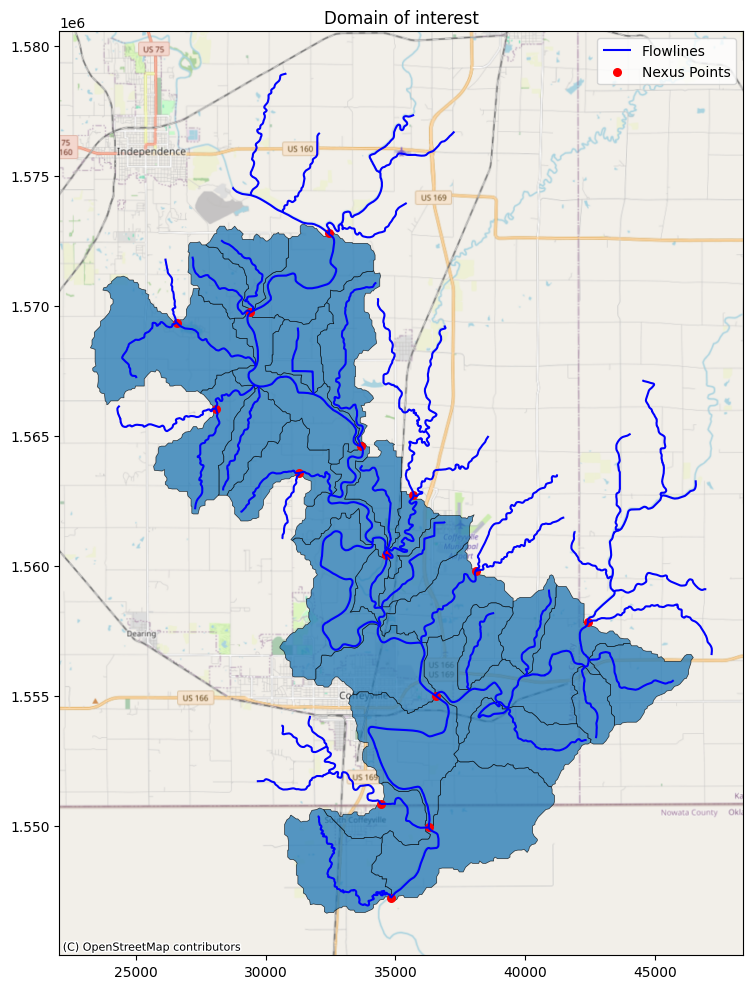

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
domain_divides.plot(ax=ax, edgecolor="k", linewidth=0.5, alpha=0.75,)
domain_flowlines.plot(ax=ax, color='blue', label='Flowlines')
domain_nexus.plot(ax=ax, color='red', markersize=30, label='Nexus Points')
try:
    cx.add_basemap(ax, crs=domain_divides.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"Couldn't add basemap: {e}")
ax.legend()
plt.title("Domain of interest")
plt.tight_layout()
plt.show()

### Setting up the grid and the model inputs

Below, we're going to set up the following inputs:
- The grid
- Elevation
- Boundary mask
- Inputs
- Boundary forcings

In [6]:
sf.setup_grid_from_region(
    region = {'geom': domain_divides},
    res= 50,
    rotated=True,
    crs=domain_divides.crs  # NAD83 / Conus Albers HARDCODED TODO figure out making this cleaner
)
# the input file is automatically updated. Uncomment to displayed below:
print(sf.config)


{'mmax': 348, 'nmax': 536, 'dx': 50, 'dy': 50, 'x0': 32075.0, 'y0': 1545718.0, 'rotation': 21.972, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


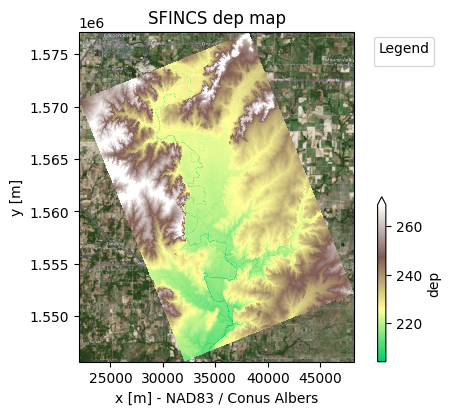

In [7]:
datasets_dep = [{"elevtn": "USGS_seamless_13", "zmin": 0.001}]
dep = sf.setup_dep(datasets_dep=datasets_dep)
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)


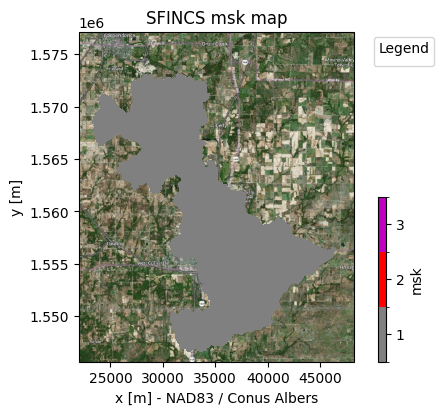

In [8]:
sf.setup_mask_active(include_mask=domain_divides,reset_mask=True)
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)


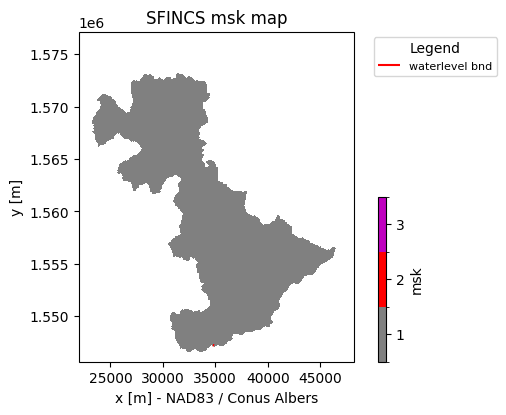

In [9]:
sf.setup_mask_bounds(btype="waterlevel", include_mask=downstream_nexus, reset_bounds=True)
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, zoomlevel=12)


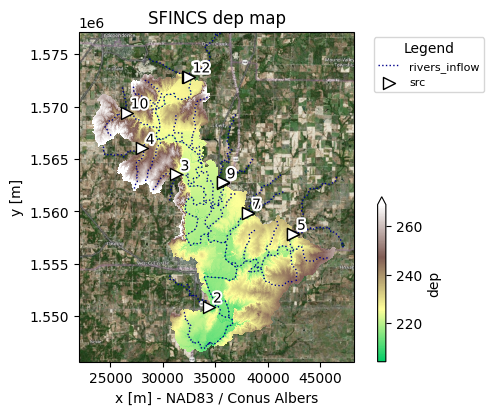

In [10]:
sf.setup_river_inflow(
    rivers=domain_flowlines, 
    buffer=10,
    keep_rivers_geom=True
)
# print(sf.config)
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)


In [11]:
network_path = Path.cwd() / "../data/NWM/domain_network.csv"
sfincs_points = sf.forcing['dis'].vector.to_gdf()
joined_flowlines = gpd.sjoin_nearest(sfincs_points, domain_flowlines, how='left')

if network_path.exists():
    domain_network = pd.read_csv(network_path)
else:
    domain_network = network[network["id"].isin(joined_flowlines["id"])]
all_comids = list(set([x for _, group in domain_network.groupby("id") 
              for x in group["hf_id"].values.astype(int).tolist()]))
output_dir = Path.cwd() / "../data/NWM/nwm30_retrospective"


In [12]:
# Commented out as this takes too long to run. Parquet file has already been processed

# !pip install teehr==0.4.6
# from datetime import datetime
# import teehr.fetching.nwm.retrospective_points as nwm_retro

# start_date = datetime(2019, 5, 20)
# end_date = datetime(2019, 6, 3)

# nwm_retro.nwm_retro_to_parquet(
#     nwm_version="nwm30",
#     variable_name="streamflow",
#     start_date=start_date,
#     end_date=end_date,
#     location_ids=all_comids,
#     output_parquet_dir=output_dir
# )


In [13]:
flow_data = pd.read_parquet(output_dir / "20190520_20190603.parquet")
flow_data[['nwm_version', 'location_id']] = flow_data['location_id'].str.split('-', expand=True)
time_range = flow_data.value_time.unique()


In [14]:
flows_arr = np.zeros((len(time_range), sf.forcing['dis'].shape[1]))
for idx, row in joined_flowlines.iterrows():
    _id = row["id"]
    inflow_segments = domain_network[domain_network["id"] == _id]
    group_ids = inflow_segments["hf_id"].values.astype(int)
    subset_flow_data = flow_data[flow_data["location_id"].astype(int).isin(group_ids)]
    summed_flows = subset_flow_data.groupby("value_time")["value"].sum().reset_index()
    flows_arr[:, idx-1] = summed_flows["value"].values

In [15]:
sf.setup_config(
    **{
        "tref": "20190520 000000",
        "tstart": "20190521 00000",
        "tstop": "20190603 000000",
        "zsini": 206.0  # Hardcoded to match domain of interest values
    }
)
index = [1]  # NOTE that the index should start at one
pnts = gpd.points_from_xy(
    [downstream_nexus.geometry.x.values[0]], # TODO CHANGE NAME TO DOWNSTREAM
    [downstream_nexus.geometry.y.values[0]],
)
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=downstream_nexus.crs)
display(bnd)
time = pd.Timestamp(utils.parse_datetime(sf.config["tstart"]))
bzs = [[206]] # hard coding the outflow boundary starting value to around the elevation
bzspd = pd.DataFrame(index=[time], columns=index, data=bzs)
display(bzspd)


,geometry
1,POINT (34816.421 1547233.167)


,1
2019-05-21,206


In [16]:
# Actually add it to the SFINCS model class:
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)

# NOTE: the waterlevel forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()


dict_keys(['dis', 'bzs'])

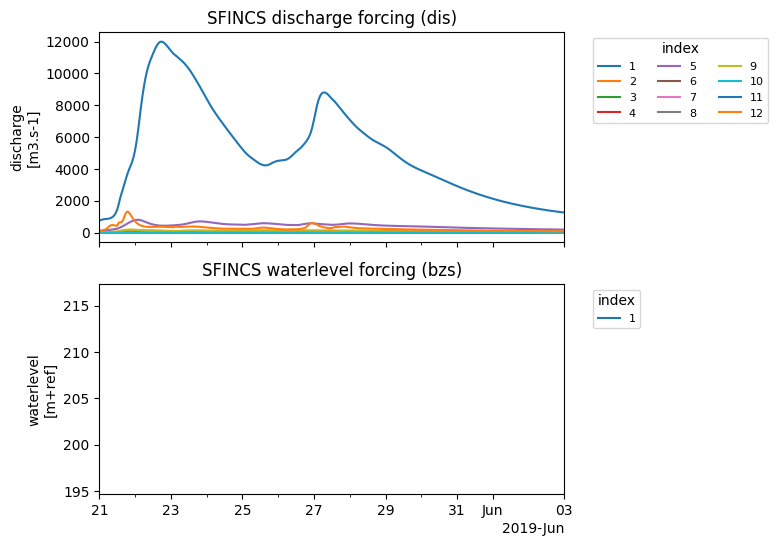

In [17]:
index = sf.forcing["dis"].index  # TODO check the units of retrospective
dispd = pd.DataFrame(index=time_range, columns=index, data=flows_arr)
sf.setup_discharge_forcing(timeseries=dispd)
_ = sf.plot_forcing(fn_out="forcing.png")


Note: The cell above is showing the correct number of m3/s. See the observations from the Coffeyville gauge during this event: https://waterdata.usgs.gov/monitoring-location/07170990/#dataTypeId=continuous-00060-0&showMedian=false&startDT=2019-05-20&endDT=2019-06-03

The NWM retro actually *underestimated* this event after unit conversion
![photo of usgs gage](../doc/USGS_flow.png)

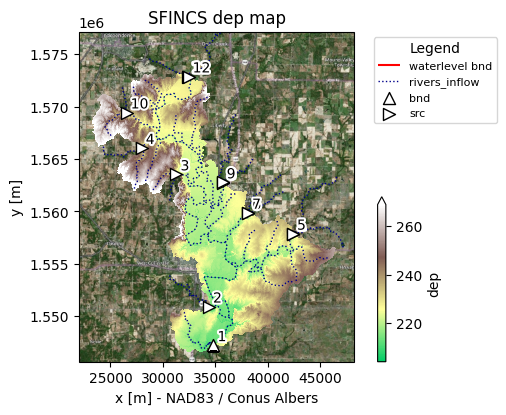

In [18]:
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)


In [19]:
sf.write()
dir_list = os.listdir(sf.root)
print(dir_list)


['sfincs.src', 'sfincs.dis', 'gis', 'sfincs.bnd', 'hydromt_data.yml', 'figs', 'sfincs.inp', 'hydromt.log', 'sfincs.dep', 'sfincs.bzs', 'sfincs.msk', 'sfincs.ind']
